In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from numpy import isnan
# Statistics functions
from scipy.stats import norm
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
!pip install boto3
import psycopg2
import sys
import boto3
import os

ENDPOINT="houseprices11.cbchqixwjhxz.us-east-2.rds.amazonaws.com"
PORT="5432"
USER="postgres"
REGION="us-east-2"
DBNAME="houseprices"

try:
     conn = psycopg2.connect(host=ENDPOINT, port=PORT, database=DBNAME, user=USER, password='finaldal', sslrootcert="SSLCERTIFICATE")
     cur = conn.cursor()
     cur.execute("""SELECT now()""")
     query_results = cur.fetchall()
     print(query_results)
except Exception as e:
     print("Database connection failed due to {}".format(e))        

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 13.5 MB/s 
     |████████████████████████████████| 79 kB 4.1 MB/s 
     |████████████████████████████████| 9.0 MB 30.5 MB/s 
     |████████████████████████████████| 139 kB 48.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.11 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
[(datetime.datetime(2022, 7, 28, 4, 31, 9, 347175, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),)]


## Extracting and Exploring the data

In [3]:
cur = conn.cursor()
cur.execute("""SELECT now()""")
query_results = cur.fetchall()
print(query_results)
      

[(datetime.datetime(2022, 7, 28, 4, 31, 9, 347175, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),)]


In [4]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    print(table)

('accuracy',)
('predictions',)
('houses',)
('prices',)
('joined_data',)
('joined_sql',)


In [5]:
import pandas.io.sql as sqlio
sql = "select * from joined_data ;"
df_data = sqlio.read_sql_query(sql, conn)
df_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
5,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,307000
7,8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,1,2008,WD,Normal,118000


Let's find out the columns which have more than 30% NA, and drop them. And let's drop the column 'Id'.

In [6]:

nb_row=df_data.shape[0]
for col in df_data.columns:
  cnt=0
  for i in range(nb_row):
     if df_data[col][i]=='NA':
      cnt=cnt+1    
  if cnt/nb_row>0.3:
      df_data.drop(col, axis =1 , inplace=True) 
df_data.drop('Id', axis =1 , inplace=True)
df_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,NA,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


### Exploring and Cleaning Numerical features


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   object
 3   LotArea        1460 non-null   int64 
 4   Street         1460 non-null   object
 5   LotShape       1460 non-null   object
 6   LandContour    1460 non-null   object
 7   Utilities      1460 non-null   object
 8   LotConfig      1460 non-null   object
 9   LandSlope      1460 non-null   object
 10  Neighborhood   1460 non-null   object
 11  Condition1     1460 non-null   object
 12  Condition2     1460 non-null   object
 13  BldgType       1460 non-null   object
 14  HouseStyle     1460 non-null   object
 15  OverallQual    1460 non-null   int64 
 16  OverallCond    1460 non-null   int64 
 17  YearBuilt      1460 non-null   int64 
 18  YearRemodAdd   1460 non-null

There are some columns which are numerical although they are object type in the dataframe. They are 'LotFrontage','LotArea','MasVnrArea' and 'GarageYrBlt'. Before starting to work on numerical features, let's change their datatype first.

In [8]:
change_datatype=['LotFrontage','LotArea','MasVnrArea','GarageYrBlt']
for i in range(len(change_datatype)):
   df_data[change_datatype[i]] = pd.to_numeric(df_data[change_datatype[i]],errors='coerce')
df_data[change_datatype].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   LotArea      1460 non-null   int64  
 2   MasVnrArea   1452 non-null   float64
 3   GarageYrBlt  1379 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 45.8 KB


In [9]:
df_data_num=df_data.select_dtypes(include=[np.number])
df_data_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


#### Dropping quisi-constant features in which 95% of the values are same or similar.

In [10]:
# 0.05: drop column where 95% of the values are constant
sel = VarianceThreshold(threshold=0.05) 

# fit finds the features with constant variance
sel.fit(df_data_num.iloc[:, :-1])


# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")

print(f"\nNumber of quasi_constant features: {len(df_data_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in df_data_num.iloc[:, :-1].columns if x not in df_data_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")

# Let's drop these columns from the data frame
df_data_num.drop(quasi_constant_features_list, axis=1, inplace=True)


Number of retained features: 35

Number of quasi_constant features: 1

Quasi-constant features to be dropped: ['KitchenAbvGr']


#### Determining Strongly correlated features and dropping them


 Correlation coefficient which is more than 0.8 suggests a strong relationship between the features, so we can drop one of the features. For this reason, we are going to look at correlation ciefficient matrix. 

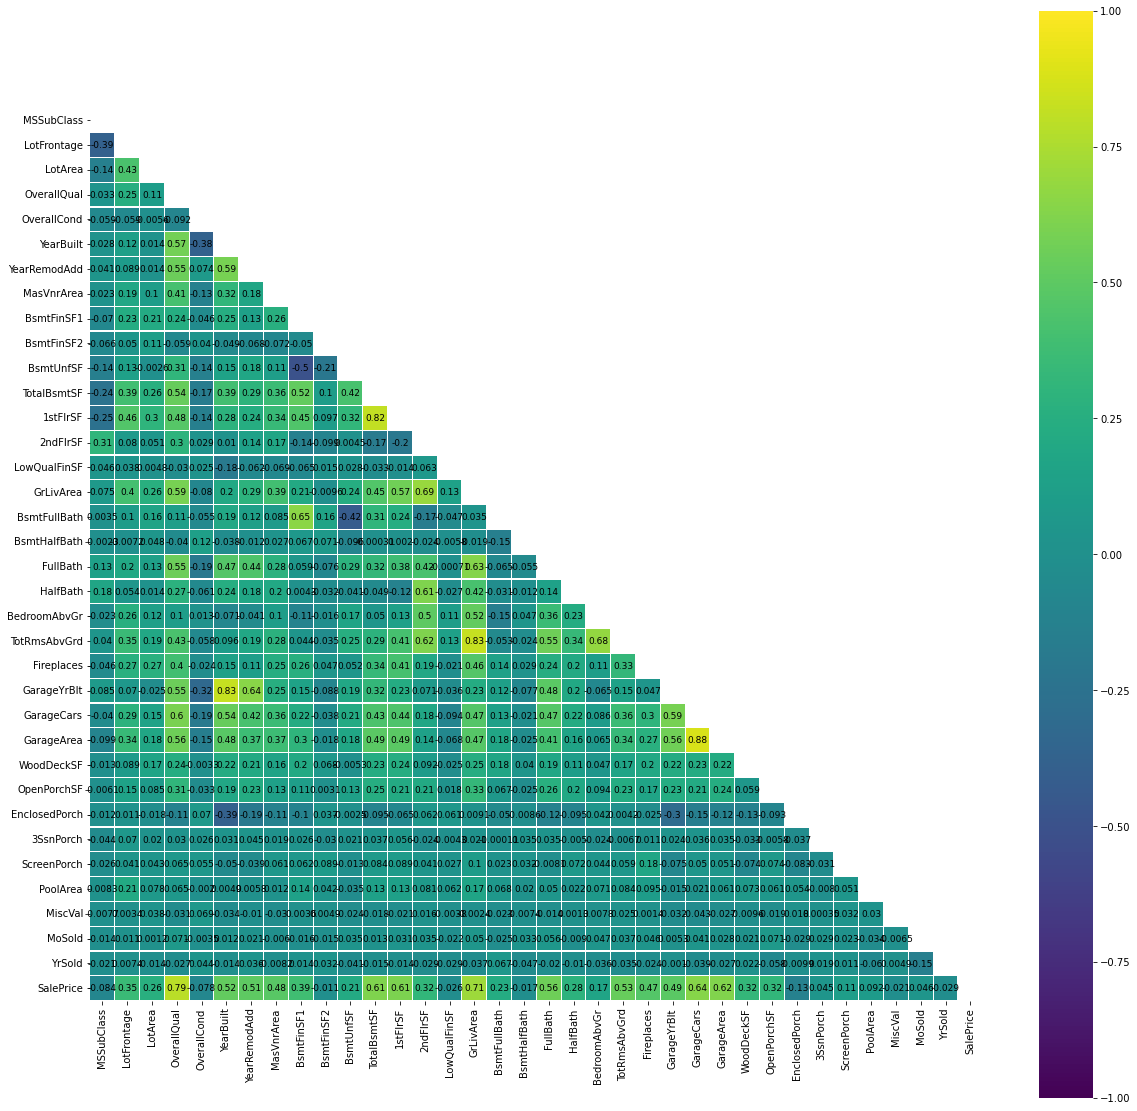

In [11]:
fig = plt.figure(figsize=(20,20))
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix 
# (method = pearson: standard correlation coefficient)
corr_matrix = df_data_num.corr(method = 'pearson')

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

According to the correlation coefficient matrix the following features have strong relation pairwisely:

"GarageArea" and "GarageCars" (0.88)


"GarageYrBlt" and "YearBuilt" (0.83)

"TotRmsAbvGrd" and "GrLivArea" (0.83)

"1stFlrSF" and "TotalBsmtSF"(0.82)

So we can drop one of the features in a a strtongly correlated pairs.

In [12]:
# Strongly Correlated Features
strong_feat = ["GarageArea", "GarageYrBlt" ,"1stFlrSF", "TotRmsAbvGrd"]
# Drop strongly corelated Features from both dataframes.
df_data_num.drop(strong_feat, axis =1 , inplace=True)

#### Determining and Dropping features which have very weak correlation with 'SalePrice'.

If the correlation coefficient between a feature and 'SalesPrice' 0.3 then we accept it as weak feature and drop it.

In [13]:
df_num_corr = df_data_num.corr()["SalePrice"][:-1]

weak_features_list = df_num_corr[abs(df_num_corr) < 0.3].sort_values(ascending=False)
print(f"{len(weak_features_list)} weakly correlated values with SalePrice:\n{weak_features_list}\n")

weak_features = df_num_corr[abs(df_num_corr) < 0.3].index.tolist()

17 weakly correlated values with SalePrice:
HalfBath         0.28
LotArea          0.26
BsmtFullBath     0.23
BsmtUnfSF        0.21
BedroomAbvGr     0.17
ScreenPorch      0.11
PoolArea         0.09
MoSold           0.05
3SsnPorch        0.04
BsmtFinSF2      -0.01
BsmtHalfBath    -0.02
MiscVal         -0.02
LowQualFinSF    -0.03
YrSold          -0.03
OverallCond     -0.08
MSSubClass      -0.08
EnclosedPorch   -0.13
Name: SalePrice, dtype: float64



In [14]:
# Remove 17 variables weakly correlated with SalePrice from the data
df_data_num.drop(weak_features,axis=1, inplace=True)

#### Missing Data Imputation of Numerical Features

In [15]:
df_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   OverallQual   1460 non-null   int64  
 2   YearBuilt     1460 non-null   int64  
 3   YearRemodAdd  1460 non-null   int64  
 4   MasVnrArea    1452 non-null   float64
 5   BsmtFinSF1    1460 non-null   int64  
 6   TotalBsmtSF   1460 non-null   int64  
 7   2ndFlrSF      1460 non-null   int64  
 8   GrLivArea     1460 non-null   int64  
 9   FullBath      1460 non-null   int64  
 10  Fireplaces    1460 non-null   int64  
 11  GarageCars    1460 non-null   int64  
 12  WoodDeckSF    1460 non-null   int64  
 13  OpenPorchSF   1460 non-null   int64  
 14  SalePrice     1460 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 171.2 KB


As we see in the above info, there are two features which have missing values to be fillied, they are 'LotFrontage' and 'MasVnrArea ' . 

We are going to use three inputation methods to fill and compare them by using shapes of the distributions before and after filling.

The imputation merthods are SimpleImputer(strategy="median"),SimpleImputer(strategy="most_frequent") and KNNInputer.

##### SimpleImputer(strategy="median")

In [16]:
# Imputation of missing values with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_data_imputed_median = pd.DataFrame(my_imputer.fit_transform(df_data_num))
df_data_imputed_median.columns = df_data_num.columns

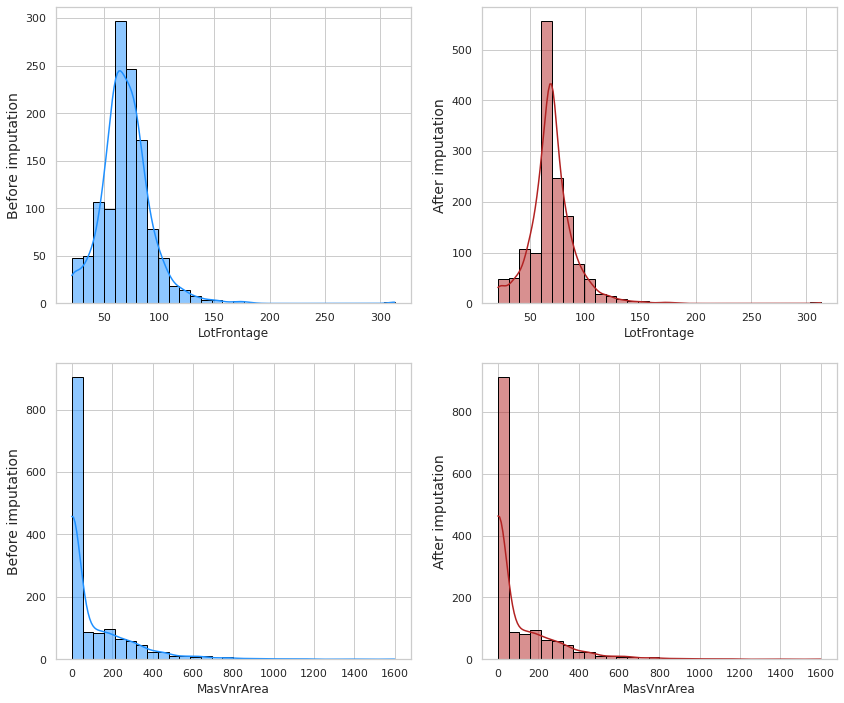

In [17]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_data_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_data_imputed_median[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

It looks this method creates a big change in the shape of 'LotFrontage' feature before and after inputing.

##### SimpleImputer(strategy="most_frequent")

In [18]:
# Imputation of missing values with SimpleImputer
my_imputer = SimpleImputer(strategy="most_frequent")
df_data_imputed_mode = pd.DataFrame(my_imputer.fit_transform(df_data_num))
df_data_imputed_mode.columns = df_data_num.columns

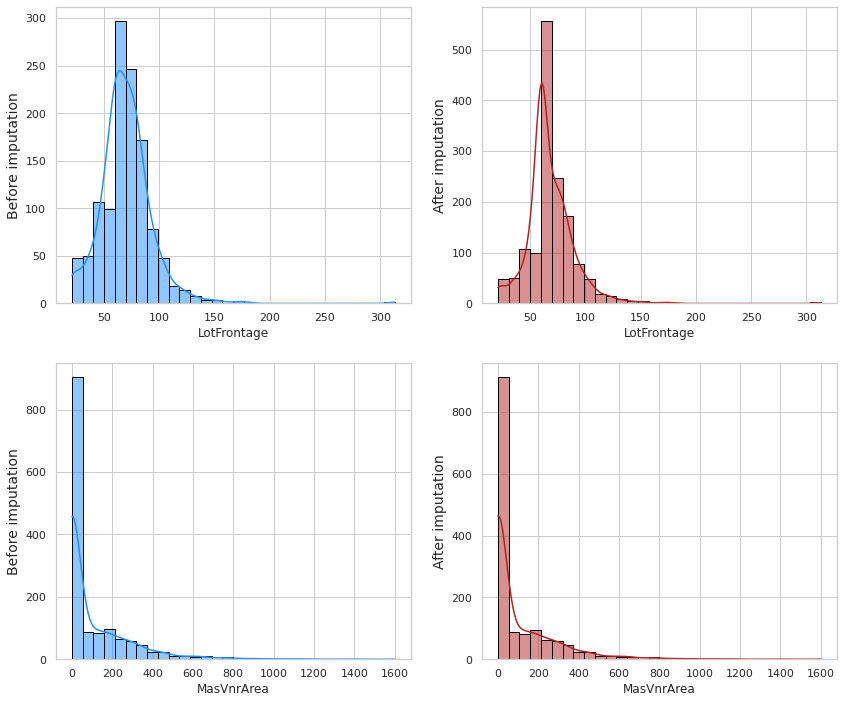

In [19]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_data_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_data_imputed_mode[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

It looks this method also creates a big change in the shape of 'LotFrontage' feature before and after inputing.

##### KNNImputer

In [20]:
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(df_data_num)
# transform the dataset
Xtrans = imputer.transform(df_data_num)
df_data_imputed_KNN=pd.DataFrame(Xtrans, columns=df_data_num.columns).astype(df_data_num.dtypes.to_dict())

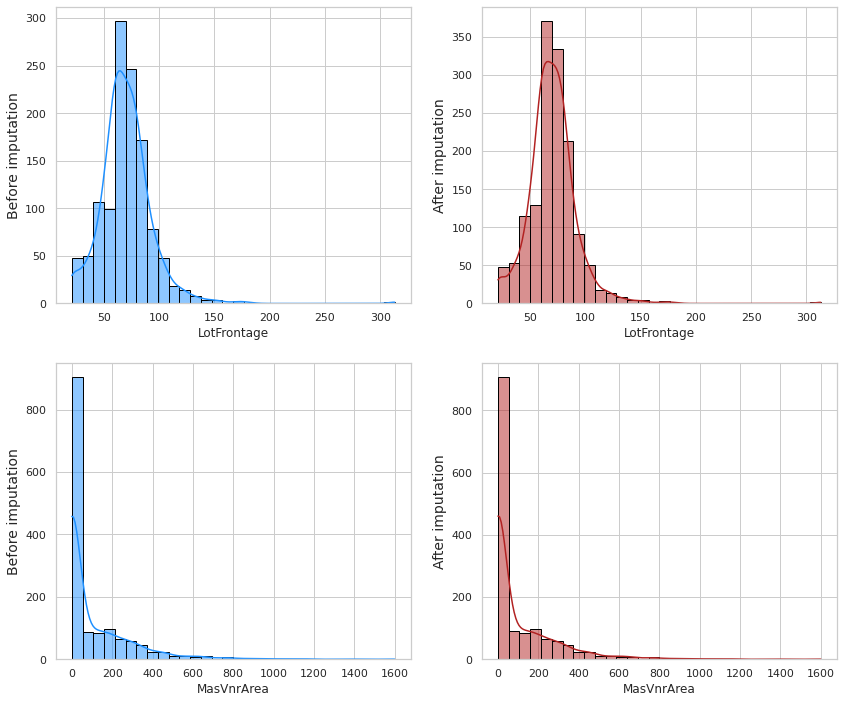

In [21]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_data_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_data_imputed_KNN[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

This method  creates a small change in the shape of 'LotFrontage' feature before and after inputing. 

So the most relevant method looks KNNImputer.

So the cleaned numerical features will be as follows:

In [22]:
df_data_imputed_KNN.head(10)

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
0,65.00,7,2003,2003,196.00,706,856,854,1710,2,0,2,0,61,208500
1,80.00,6,1976,1976,0.00,978,1262,0,1262,2,1,2,298,0,181500
2,68.00,7,2001,2002,162.00,486,920,866,1786,2,1,2,0,42,223500
3,60.00,7,1915,1970,0.00,216,756,756,1717,1,1,3,0,35,140000
4,84.00,8,2000,2000,350.00,655,1145,1053,2198,2,1,3,192,84,250000
5,85.00,5,1993,1995,0.00,732,796,566,1362,1,0,2,40,30,143000
6,75.00,8,2004,2005,186.00,1369,1686,0,1694,2,1,2,255,57,307000
7,77.80,7,1973,1973,240.00,859,1107,983,2090,2,2,2,235,204,200000
8,51.00,7,1931,1950,0.00,0,952,752,1774,2,2,2,90,0,129900
9,50.00,5,1939,1950,0.00,851,991,0,1077,1,2,1,0,4,118000


In [23]:

df_data_imputed_KNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1460 non-null   float64
 1   OverallQual   1460 non-null   int64  
 2   YearBuilt     1460 non-null   int64  
 3   YearRemodAdd  1460 non-null   int64  
 4   MasVnrArea    1460 non-null   float64
 5   BsmtFinSF1    1460 non-null   int64  
 6   TotalBsmtSF   1460 non-null   int64  
 7   2ndFlrSF      1460 non-null   int64  
 8   GrLivArea     1460 non-null   int64  
 9   FullBath      1460 non-null   int64  
 10  Fireplaces    1460 non-null   int64  
 11  GarageCars    1460 non-null   int64  
 12  WoodDeckSF    1460 non-null   int64  
 13  OpenPorchSF   1460 non-null   int64  
 14  SalePrice     1460 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 171.2 KB


### Exploring and Cleaning Categorical features

In [24]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [25]:
categorical_features = [i for i in df_data.columns if df_data.dtypes[i] == "object"]
categorical_features.append("SalePrice")

# Train set
df_data_categ = df_data[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')

df_data_categ.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [26]:
print(f"Training set shape (Categorical features): {df_data_categ.shape}\n")

Training set shape (Categorical features): (1460, 39)



In [27]:
df_data_categ

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,175000
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal,210000
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,266500
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal,142125


There are 38 categorical features. As it is seen in the dataframe above some of them such as

'Street',    'LandContour','Utilities','LandSlope','Condition2',
'RoofMatl', 'BsmtCond','BsmtFinType2', 'Heating',  'CentralAir',
'Electrical','Functional', 'GarageQual','GarageCond', 'PavedDrive

have similar or the same values, so they do not create significant change in the price. 

We are going to drop these features.


In [28]:
cols_to_drop = [
    'Street',
    'LandContour',
    'Utilities',
    'LandSlope',
    'Condition2',
    'RoofMatl',
    'BsmtCond',
    'BsmtFinType2',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageQual',
    'GarageCond',
    'PavedDrive'
]

# Drop these columns from dataset
df_data_categ.drop(cols_to_drop, axis=1, inplace=True)


In [29]:
print(f"Data set shape (Categorical features): {df_data_categ.shape}\n")

Data set shape (Categorical features): (1460, 24)



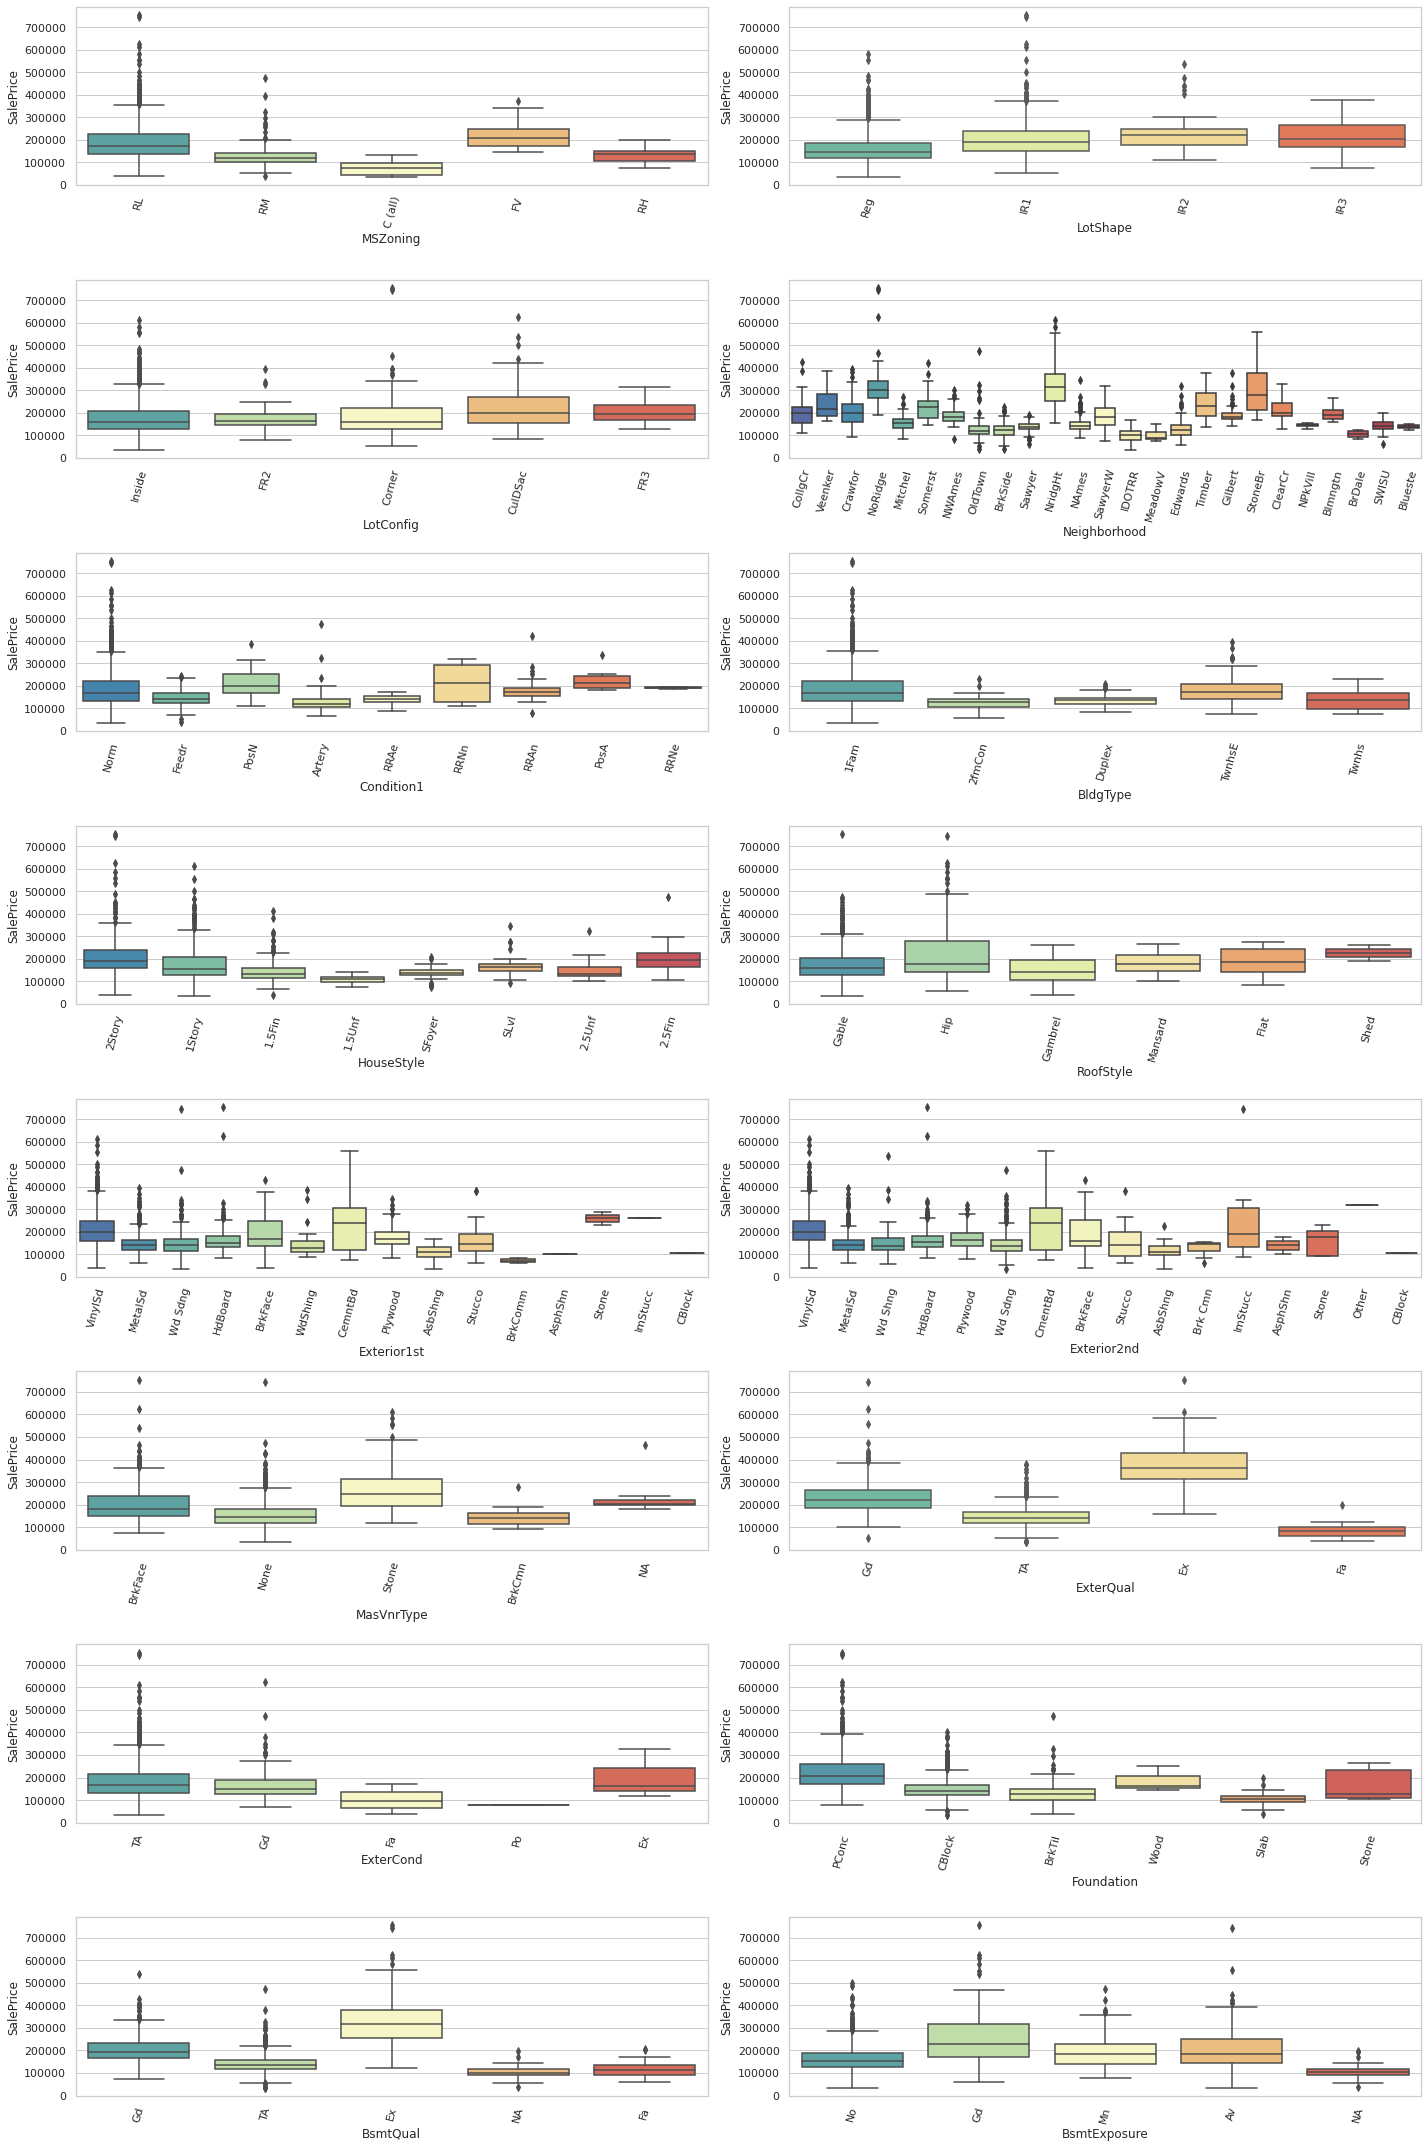

In [30]:
fig, axes = plt.subplots(
    round(len(df_data_categ.columns)/3), 2, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    # plot the variation of SalePrice in each feature
    if i < len(df_data_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
        sns.boxplot(x=df_data_categ.columns[i], y="SalePrice", data=df_data_categ, ax=ax, palette="Spectral_r")

fig.tight_layout()

If we look at closely the box plots above, we can see that there are three pairs of categorical variables for which the distribution of sale price is very similar, they are

"Exterior1st" and "Exterior2nd"

"ExterQual" and "MasVnrType"

"BsmtQual" and "BsmtExposure"

It looks they are dependent pairwisely. We are going to check if they are dependent or independent by using Chi-Square test.

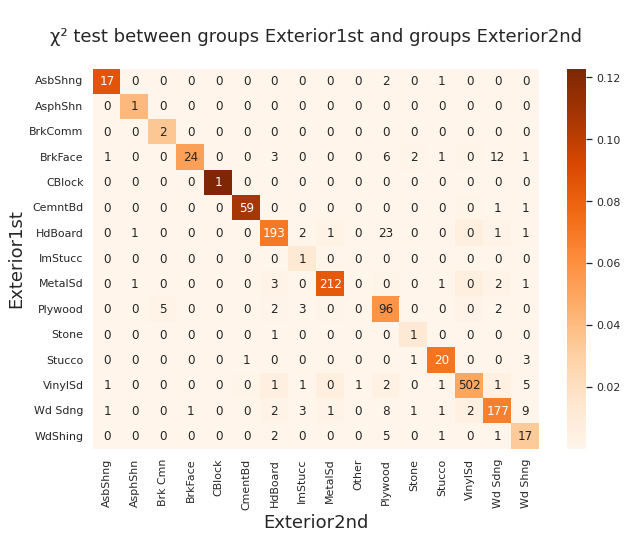

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0



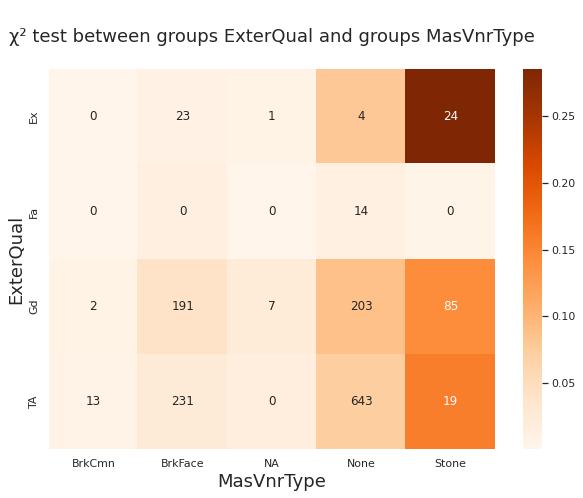

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 4.7495842936129416e-55



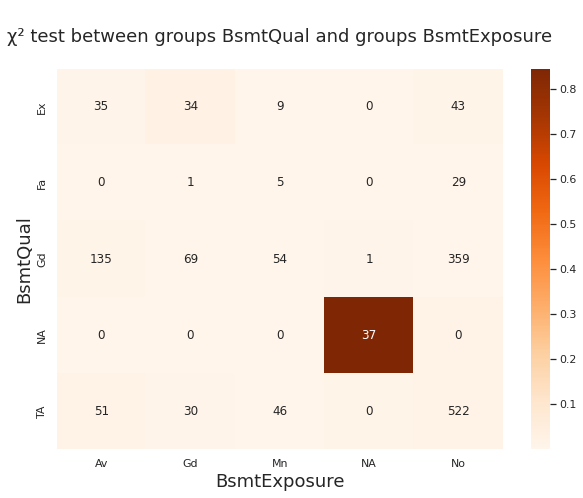

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 0.0



In [31]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtExposure"]

for i, j in zip(X, Y):

    # Contingency table
    cont = df_data_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_data_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_data_categ[i], columns=df_data_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(
        f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")

If we look at p-values, they are all very small, almost zero. 


So, the categorical features which we rae working on are pairwisely dependent, they are correlated. That means dropping one of the features ain a pair does not effect too much in the house prise, se we can drop them.


Let's drop second features in each pair, they are "Exterior2nd", "MasVnrType"and "BsmtExposure"

In [32]:
# Drop the one of each co-dependent variables
df_data_categ.drop(Y, axis=1, inplace=True)
# Drop the SalePrice column from the df_data_categ dataset
df_data_categ.drop("SalePrice", axis=1, inplace=True)

In [33]:
df_data_categ.shape

(1460, 20)

Big success, there are just 20 categorical features to be handle missing data.

#### Handling Missing data of Categorical Features

In [34]:
df_data_categ

,MSZoning,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,ExterQual,ExterCond,Foundation,BsmtQual,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish,SaleType,SaleCondition
0,RL,Reg,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,Gd,TA,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
1,RL,Reg,FR2,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,TA,TA,CBlock,Gd,ALQ,Ex,TA,Attchd,RFn,WD,Normal
2,RL,IR1,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,Gd,TA,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
3,RL,IR1,Corner,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,TA,TA,BrkTil,TA,ALQ,Gd,Gd,Detchd,Unf,WD,Abnorml
4,RL,IR1,FR2,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,Gd,TA,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,TA,TA,PConc,Gd,Unf,Ex,TA,Attchd,RFn,WD,Normal
1456,RL,Reg,Inside,NWAmes,Norm,1Fam,1Story,Gable,Plywood,TA,TA,CBlock,Gd,ALQ,TA,TA,Attchd,Unf,WD,Normal
1457,RL,Reg,Inside,Crawfor,Norm,1Fam,2Story,Gable,CemntBd,Ex,Gd,Stone,TA,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
1458,RL,Reg,Inside,NAmes,Norm,1Fam,1Story,Hip,MetalSd,TA,TA,CBlock,TA,GLQ,Gd,Gd,Attchd,Unf,WD,Normal


As it is seen there is small amount of missing element and first elemnt of each column is not missing.

So we are going to fill the missing elemnt by first element of each column.

In [35]:
# Filling missing elements by top elemnt of each column.
for col in df_data_categ.columns:
  for i in range(nb_row):
    if df_data_categ[col][i]=='NA':
      df_data_categ[col][i]=df_data_categ[col][0]

#### Transforming The categorical features to Binary Features

In [36]:

# Use get_dummies to transform the Categorical features into Binary features (Training dataset)
df_data_dummies = pd.get_dummies(df_data_categ)
df_data_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### Merge Numerical and Categorical Features

In [37]:
# Training set
df_data_new = pd.concat([df_data_imputed_KNN, df_data_dummies], axis = 1)
print(f"Train set: {df_data_new.shape}")

Train set: (1460, 155)


The Year of construction and the Year of Remodelling variables will be transformed into new variables representing the Age of the House and the Age since the house was remodelled.

The new variable will be called as 'AgeSinceConst' and 'AgeSinceRemode; after that the columns 'YearBuilt' and 'YearRemodAdd' will be droped

In [38]:
# importing date class from datetime module
from datetime import date 
# creating the date object of today's date
todays_date = date.today()
# Convert Year of construction to the Age of the house since the construction
df_data_new["AgeSinceConst"] = todays_date.year - df_data_new["YearBuilt"]
# Drop "YearBuilt"
df_data_new.drop(["YearBuilt"], axis=1, inplace=True)
print(df_data_new["AgeSinceConst"])

0        19
1        46
2        21
3       107
4        22
       ... 
1455     23
1456     44
1457     81
1458     72
1459     57
Name: AgeSinceConst, Length: 1460, dtype: int64


In [39]:
# Convert Year of remodeling to the Age of the house since the remodeling
df_data_new["AgeSinceRemod"] =todays_date.year - df_data_new["YearRemodAdd"]
# Drop "YearRemodAdd"
df_data_new.drop(["YearRemodAdd"], axis=1, inplace=True)

Let's find skew features and apply log transformation to them.

In [40]:
continuous_features = ["OverallQual", "GrLivArea",
                       "FullBath", "GarageCars",
                       "MasVnrArea", "Fireplaces",
                        "AgeSinceConst", "AgeSinceRemod"]
df_skew_verify = df_data_new.loc[:, continuous_features]
df_skew_verify

,OverallQual,GrLivArea,FullBath,GarageCars,MasVnrArea,Fireplaces,AgeSinceConst,AgeSinceRemod
0,7,1710,2,2,196.00,0,19,19
1,6,1262,2,2,0.00,1,46,46
2,7,1786,2,2,162.00,1,21,20
3,7,1717,1,3,0.00,1,107,52
4,8,2198,2,3,350.00,1,22,22
...,...,...,...,...,...,...,...,...
1455,6,1647,2,2,0.00,1,23,22
1456,6,2073,2,2,119.00,2,44,34
1457,7,2340,2,1,0.00,2,81,16
1458,5,1078,1,1,0.00,0,72,26


In [41]:
# Select features with absolute Skew higher than 0.5
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame({"Columns": continuous_features,
                          "Abs_Skew": skew_ft})

sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print(f"List of skewed features: {sk_features}")

List of skewed features: ['GrLivArea', 'MasVnrArea', 'Fireplaces', 'AgeSinceConst', 'AgeSinceRemod']


In [42]:
# Log transformation of the skewed features

for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Train set
    df_data_new[i] = np.log((df_data_new[i])+1)
    

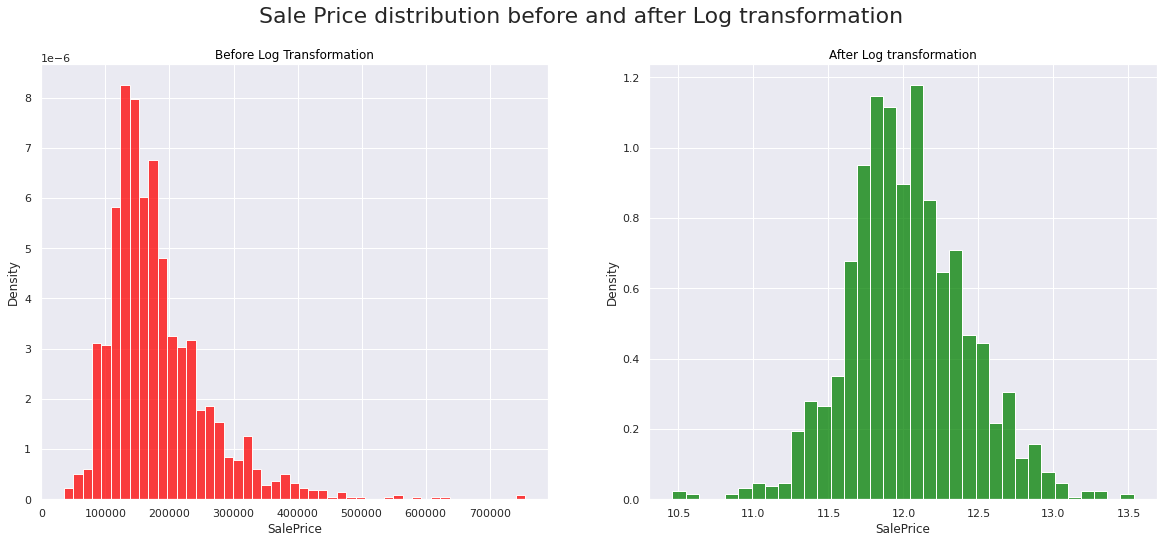

In [43]:
from sklearn.preprocessing import FunctionTransformer
Y = df_data_new[["SalePrice"]]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SalePrice', stat="density", ax=axes[0],color='red')
axes[0].set_title("Before Log Transformation", color='black')
sns.histplot(data=Y_log, x='SalePrice', stat="density", ax=axes[1],color='green')
axes[1].set_title("After Log transformation", color='black')
plt.suptitle("Sale Price distribution before and after Log transformation",fontsize=22)
plt.show()

In [44]:
# Log transformation of the target variable "SalePrice"
df_data_new["SalePriceLog"] = np.log(df_data_new.SalePrice)
# Drop the original SalePrice
df_data_new.drop(["SalePrice"], axis=1, inplace=True)

## Creating Liner Regression Models

In [45]:
# Extract the features (X) and the target (y)
# Features (X)
X = df_data_new[[i for i in list(
    df_data_new.columns) if i != "SalePriceLog"]]
print(X.shape)

# Target (y)
y = df_data_new.loc[:, "SalePriceLog"]
print(y.shape)

(1460, 154)
(1460,)


In [46]:
from sklearn.model_selection import train_test_split
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(1168, 154)
y_train:(1168,)

X_test:(292, 154)
y_test:(292,)


In [47]:
# Test data will be the same as the new data
df_test_new=df_data_new
# Drop the column "SalePrice" from the test data
df_test_new.drop(["SalePriceLog"], axis=1, inplace=True)

In [48]:
from sklearn import preprocessing

# Standardize the data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
df_test_new = std_scale.transform(df_test_new)

#### Evaluation of the Models

In [49]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
 
dummy_reg = DummyRegressor(strategy="median")
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
adaboost = AdaBoostRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
xgbreg=XGBRegressor(random_state=42)

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
model = [dummy_reg,ridge, lasso, dt_reg,adaboost, bagging, gdboost, rdmforest,xgbreg]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    dict_model[model] = (mae, mse, rmse, r_score)

results = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "r_score"])
results.columns = ["Dummy Regressor", "Ridge", "Lasso", "DecisionTree",
                      "AdaBoost", "Bagging", "GradientBoosting", "Random Forest","XGBoost Regressor"]

results

[04:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Dummy Regressor,Ridge,Lasso,DecisionTree,AdaBoost,Bagging,GradientBoosting,Random Forest,XGBoost Regressor
MAE,0.33,0.10,0.33,0.14,0.14,0.10,0.09,0.10,0.10
MSE,0.19,0.02,0.19,0.05,0.03,0.02,0.02,0.02,0.02
RMSE,0.43,0.14,0.43,0.21,0.19,0.15,0.14,0.15,0.15
r_score,-0.01,0.90,-0.01,0.75,0.81,0.88,0.89,0.87,0.87


Among these 9 methods the ones which have r_score (correlation coefficient) more than 0.85  are going to be accepted as acurate models. According to this assumption, methods 'Ridge', 'GradientBoosting', 'Bagging', 'Random Forest' and 'XGBoost Regressor' are acurate, given in decending order according to r_scores.

Although the methods 'DecisionTree' and 'AdaBoost' are not according to our assumption, they are also good enough in accuracy.

The methods 'Dumme Regressor' and 'Lasso' worked in very low accuracy in predicting the house prices in our case.

We are going to create a dateframe containing, actual prices and predicted prices of the acurate models.

In [51]:
from sklearn.model_selection import GridSearchCV
# Define hyperparameters
alphas = np.logspace(-5, 5, 50).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(random_state=42), tuned_parameters, cv=5, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
ridge_cv.fit(X_train, y_train)
# Ridge Regressor with the best hyperparameters
ridge_Reg = Ridge(alpha=ridge_cv.best_params_["alpha"])
# Fit the model on train set
ridge_Reg.fit(X_train, y_train)
# Predict on test set
y_pred = ridge_Reg.predict(X_test)

# Prediction of House Prices using ridge Regressor Model

y_pred_ridge = ridge_Reg.predict(df_test_new)

# Conversion of logarithmic predictions to logical data Sale Price
saleprice_preds_ridge = np.exp(y_pred_ridge)

df_salesprices_with_predictions = pd.DataFrame({"ActSalePrice": df_data['SalePrice'],"SalePriceRidge": saleprice_preds_ridge})
df_salesprices_with_predictions

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,ActSalePrice,SalePriceRidge
0,208500,"207,551.09"
1,181500,"186,463.40"
2,223500,"220,122.01"
3,140000,"184,079.66"
4,250000,"288,837.30"
...,...,...
1455,175000,"174,795.37"
1456,210000,"209,435.93"
1457,266500,"268,148.73"
1458,142125,"140,773.52"


In [52]:
#GradienBoosting Regressor with the best hyperparameters
GradBoost_Reg=GradientBoostingRegressor(n_estimators=500,max_leaf_nodes=5)
# fit the GridSearch on train set
GradBoost_Reg.fit(X_train,y_train)
# Predict on test set
y_pred= GradBoost_Reg.predict(X_test)

# Prediction of House Prices using GradienBoosting Regressor Model

y_pred_GradBoost = GradBoost_Reg.predict(df_test_new)

# Conversion of logarithmic predictions to logical data Sale Price
saleprice_preds_GradBoost = np.exp(y_pred_GradBoost)

df_salesprices_with_predictions['SalePriceGradBoost']=saleprice_preds_GradBoost

df_salesprices_with_predictions

,ActSalePrice,SalePriceRidge,SalePriceGradBoost
0,208500,"207,551.09","204,628.33"
1,181500,"186,463.40","176,425.86"
2,223500,"220,122.01","206,374.14"
3,140000,"184,079.66","154,088.65"
4,250000,"288,837.30","278,603.23"
...,...,...,...
1455,175000,"174,795.37","175,898.53"
1456,210000,"209,435.93","214,496.89"
1457,266500,"268,148.73","275,400.62"
1458,142125,"140,773.52","135,499.58"


In [53]:
# Importing Bagging Regressor Library
from sklearn.ensemble import BaggingRegressor
# Initilizing and fitting the model
baggingR = BaggingRegressor()
baggingR.fit(X_train,y_train)
# Predict on test set
y_pred= baggingR.predict(X_test)

# Prediction of House Prices using Bagging Regressor Model
y_pred_Bagging = baggingR.predict(df_test_new)

# Conversion of logarithmic predictions to logical data Sale Price
saleprice_preds_Bagging = np.exp(y_pred_Bagging)

df_salesprices_with_predictions['SalePriceBagging']=saleprice_preds_Bagging

df_salesprices_with_predictions


,ActSalePrice,SalePriceRidge,SalePriceGradBoost,SalePriceBagging
0,208500,"207,551.09","204,628.33","202,702.44"
1,181500,"186,463.40","176,425.86","179,602.34"
2,223500,"220,122.01","206,374.14","218,876.78"
3,140000,"184,079.66","154,088.65","163,436.36"
4,250000,"288,837.30","278,603.23","256,534.93"
...,...,...,...,...
1455,175000,"174,795.37","175,898.53","174,239.29"
1456,210000,"209,435.93","214,496.89","212,854.49"
1457,266500,"268,148.73","275,400.62","259,244.71"
1458,142125,"140,773.52","135,499.58","140,509.97"


In [54]:
# Importing Random Forest Regressor Library
from sklearn.ensemble import RandomForestRegressor
# Initilizing and fitting the model
RandForR =  RandomForestRegressor()
RandForR.fit(X_train,y_train)
# Predict on test set
y_pred= RandForR.predict(X_test)

# Prediction of House Prices using Random Forest Regressor Model
y_pred_RandFor = RandForR.predict(df_test_new)

# Conversion of logarithmic predictions to logical data Sale Price
saleprice_preds_RandFor = np.exp(y_pred_RandFor)

df_salesprices_with_predictions['SalePriceRandFor']=saleprice_preds_RandFor

df_salesprices_with_predictions


,ActSalePrice,SalePriceRidge,SalePriceGradBoost,SalePriceBagging,SalePriceRandFor
0,208500,"207,551.09","204,628.33","202,702.44","207,175.73"
1,181500,"186,463.40","176,425.86","179,602.34","178,748.74"
2,223500,"220,122.01","206,374.14","218,876.78","216,870.02"
3,140000,"184,079.66","154,088.65","163,436.36","158,596.25"
4,250000,"288,837.30","278,603.23","256,534.93","262,483.65"
...,...,...,...,...,...
1455,175000,"174,795.37","175,898.53","174,239.29","175,427.07"
1456,210000,"209,435.93","214,496.89","212,854.49","209,697.17"
1457,266500,"268,148.73","275,400.62","259,244.71","263,498.63"
1458,142125,"140,773.52","135,499.58","140,509.97","138,627.48"


In [55]:
# Importing XgBoost Regressor Librory
from xgboost import XGBRegressor 
# Initilizing and fitting the model
XgboostR =  XGBRegressor()
XgboostR.fit(X_train,y_train)
# Predict on test set
y_pred= XgboostR.predict(X_test)

# Prediction of House Prices using Random Forest Regressor Model
y_pred_Xgboost = XgboostR.predict(df_test_new)

# Conversion of logarithmic predictions to logical data Sale Price
saleprice_preds_Xgboost = np.exp(y_pred_Xgboost)

df_salesprices_with_predictions['SalePriceXgboost']=saleprice_preds_Xgboost

df_salesprices_with_predictions

[04:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,ActSalePrice,SalePriceRidge,SalePriceGradBoost,SalePriceBagging,SalePriceRandFor,SalePriceXgboost
0,208500,"207,551.09","204,628.33","202,702.44","207,175.73","209,521.28"
1,181500,"186,463.40","176,425.86","179,602.34","178,748.74","168,408.23"
2,223500,"220,122.01","206,374.14","218,876.78","216,870.02","213,797.02"
3,140000,"184,079.66","154,088.65","163,436.36","158,596.25","162,667.12"
4,250000,"288,837.30","278,603.23","256,534.93","262,483.65","294,515.59"
...,...,...,...,...,...,...
1455,175000,"174,795.37","175,898.53","174,239.29","175,427.07","171,128.98"
1456,210000,"209,435.93","214,496.89","212,854.49","209,697.17","218,437.09"
1457,266500,"268,148.73","275,400.62","259,244.71","263,498.63","271,427.34"
1458,142125,"140,773.52","135,499.58","140,509.97","138,627.48","131,240.80"


### Theree hybrid methods

By using these best 5 pridiction we are going to develop three more methods:

**1.**  **MinMax Predictor** is the average of minimum and maximum of the best five pridictions.

**2.** **Weigheted Predictor"** is crearted by the weights of minimum and maximum based on the percentage of actual values which are smaller than minimum and prcentage ofv actual values which are more than maximum.

**3.** **Average predictor** is the average of these five prediction.

In [56]:
import numpy as np
df_predictions=df_salesprices_with_predictions.drop('ActSalePrice',axis=1)
nb_rows=df_predictions.shape[0]
cnt_less_than_min=0
cnt_more_than_max=0
for i in range(nb_row):
   lst=[]
   for col in df_predictions.columns:
     lst.append(df_predictions[col][i])  
   mn=np.min(lst)
   mx=np.max(lst)
   if mn>df_salesprices_with_predictions['ActSalePrice'][i]:
      cnt_less_than_min=cnt_less_than_min+1
   if mx<df_salesprices_with_predictions['ActSalePrice'][i]:
      cnt_more_than_max=cnt_more_than_max+1
prcnt_less_than_min=100*cnt_less_than_min/nb_rows
prcnt_more_than_max=100*cnt_more_than_max/nb_rows

print(f"The percentage of actual price which are less than minimum of predicted prices is",prcnt_less_than_min)
print(f"The percentage of actual price which are more than maximum of predicted prices is",prcnt_more_than_max)

The percentage of actual price which are less than minimum of predicted prices is 25.273972602739725
The percentage of actual price which are more than maximum of predicted prices is 28.356164383561644


In [57]:

import numpy as np

sum_proportion=prcnt_less_than_min+prcnt_more_than_max
lweight=prcnt_less_than_min/sum_proportion
rweight=prcnt_more_than_max/sum_proportion

minmax_predictor=[]
average_predictor=[]
weighted_predictor=[]
for i in range(nb_row):
   lst=[]
   for col in df_predictions.columns:
     lst.append(df_predictions[col][i]) 
   mn=np.min(lst)
   mx=np.max(lst)
   avrg=np.mean(lst)
   minmax_predictor.append((mn+mx)/2)
   average_predictor.append(avrg)
   weighted_predictor.append(lweight*mn+rweight*mx)
df_salesprices_with_predictions['SalePriceMinMax']=minmax_predictor
df_salesprices_with_predictions['SalePriceAverage']=average_predictor
df_salesprices_with_predictions['SalePriceWeighted']=weighted_predictor

df_salesprices_with_predictions


,ActSalePrice,SalePriceRidge,SalePriceGradBoost,SalePriceBagging,SalePriceRandFor,SalePriceXgboost,SalePriceMinMax,SalePriceAverage,SalePriceWeighted
0,208500,"207,551.09","204,628.33","202,702.44","207,175.73","209,521.28","206,111.86","206,315.77","206,307.81"
1,181500,"186,463.40","176,425.86","179,602.34","178,748.74","168,408.23","177,435.82","177,929.71","177,954.64"
2,223500,"220,122.01","206,374.14","218,876.78","216,870.02","213,797.02","213,248.07","215,207.99","213,643.13"
3,140000,"184,079.66","154,088.65","163,436.36","158,596.25","162,667.12","169,084.15","164,573.61","169,945.96"
4,250000,"288,837.30","278,603.23","256,534.93","262,483.65","294,515.59","275,525.26","276,194.94","276,616.66"
...,...,...,...,...,...,...,...,...,...
1455,175000,"174,795.37","175,898.53","174,239.29","175,427.07","171,128.98","173,513.76","174,297.85","173,650.81"
1456,210000,"209,435.93","214,496.89","212,854.49","209,697.17","218,437.09","213,936.51","212,984.32","214,195.17"
1457,266500,"268,148.73","275,400.62","259,244.71","263,498.63","271,427.34","267,322.67","267,544.01","267,786.92"
1458,142125,"140,773.52","135,499.58","140,509.97","138,627.48","131,240.80","136,007.16","137,330.27","136,281.09"


### Analysis and Visualization of the results

In [58]:
# The function to evaluate the accuracy by Mean Absolute Percentage Error (mape)
import numpy as np

def MeanAbsPerErr(y_actual, y_pred):  
    mape=np.mean(100*np.abs(np.array(y_actual)-np.array(y_pred))/np.array(y_actual))
    return mape

In [59]:
# The function to find Pearson Correlation Coefficient
import numpy as np
def PearsonCoefficient(x, y):
  assert len(x) == len(y)
  n = len(x)
  assert n > 0
  avg_x = float(sum(x)) / n
  avg_y = float(sum(y)) / n
  diffprod = 0
  xdiff2 = 0
  ydiff2 = 0
  for idx in range(n):
    xdiff = x[idx] - avg_x
    ydiff = y[idx] - avg_y
    diffprod += xdiff * ydiff
    xdiff2 += xdiff * xdiff
    ydiff2 += ydiff * ydiff

  p = np.sqrt(xdiff2 * ydiff2)
  if p == 0:
    return None
  return diffprod / p

In [60]:
# import pandas library as pd
import pandas as pd
 
# Create dataframe which just contain pridected sale parices
predictions_df=df_salesprices_with_predictions.drop('ActSalePrice',axis=1)
# Create an Empty DataFrame for accuracy table
accuracy_df=pd.DataFrame()
#accuracy_df['MeasureAccuracy']=['MeanAbsPerErr','r_score']
accuracy_df.index=['MeanAbsPerErr','r_score']
for col in predictions_df.columns:
  maperr=MeanAbsPerErr(df_salesprices_with_predictions['ActSalePrice'],predictions_df[col])
  PearCoef=PearsonCoefficient(df_salesprices_with_predictions['ActSalePrice'],predictions_df[col])
  accuracy_df[col]=[maperr.round(3),PearCoef.round(3)]
print(accuracy_df)


               SalePriceRidge  SalePriceGradBoost  SalePriceBagging  \
MeanAbsPerErr            8.99                5.51              5.84   
r_score                  0.94                0.98              0.97   

               SalePriceRandFor  SalePriceXgboost  SalePriceMinMax  \
MeanAbsPerErr              5.22              7.67             6.52   
r_score                    0.98              0.96             0.97   

               SalePriceAverage  SalePriceWeighted  
MeanAbsPerErr              6.03               6.55  
r_score                    0.98               0.97  


### Comparison of evaluation of nine models according to Test Sale Price (y-test)

In [61]:
results_t=results.transpose()
results_t.reset_index(inplace=True)
results_t.rename(columns={"index": "Model"},inplace=True)

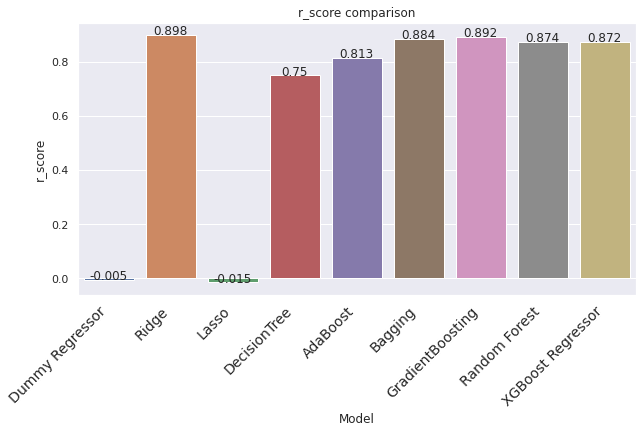

In [62]:
# Camparing r_scores of nine models by bar graph
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  x=results_t['Model']
  y = results_t['r_score'].round(3)

  plt.figure(figsize=(10,5))
  plt.title('r_score comparison')
  ax = sns.barplot(x = results_t['Model'], y = results_t['r_score'])
  addlabels(x, y)
  ax.set_xticklabels(labels = results_t['Model'], rotation=45, horizontalalignment='right',size=14)

  plt.show()

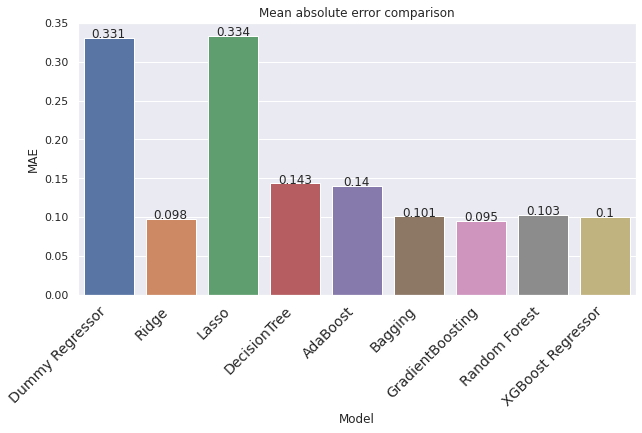

In [63]:
# Camparing Mean absolute percentage error of nine models by bar graph
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  x=results_t['Model']
  y = results_t['MAE'].round(3)

  plt.figure(figsize=(10,5))
  plt.title('Mean absolute error comparison')
  ax = sns.barplot(x = results_t['Model'], y = results_t['MAE'])
  addlabels(x, y)
  ax.set_xticklabels(labels = results_t['Model'], rotation=45, horizontalalignment='right',size=14)

  plt.show()

### Comparison of accuracy of best five models and created hibrid models according to all sale prices (y-tarin and y-test together)

In [64]:
accuracy_df_t=accuracy_df.transpose()
accuracy_df_t.reset_index(inplace=True)
accuracy_df_t.rename(columns={"index": "Model"},inplace=True)
print(accuracy_df_t)

                Model  MeanAbsPerErr  r_score
0      SalePriceRidge           8.99     0.94
1  SalePriceGradBoost           5.51     0.98
2    SalePriceBagging           5.84     0.97
3    SalePriceRandFor           5.22     0.98
4    SalePriceXgboost           7.67     0.96
5     SalePriceMinMax           6.52     0.97
6    SalePriceAverage           6.03     0.98
7   SalePriceWeighted           6.55     0.97


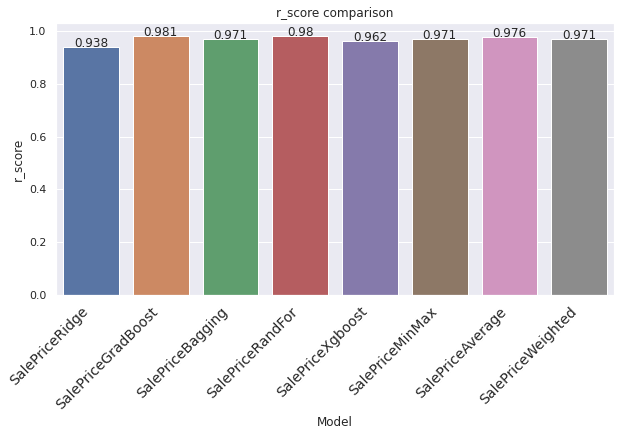

In [65]:
# Camparing r_scores five best models and three created hibrid models models by bar graph
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center') 
if __name__ == '__main__':

  x=accuracy_df_t['Model']
  y=accuracy_df_t['r_score'].round(3)
  plt.figure(figsize=(10,5))
  plt.title('r_score comparison')
  ax = sns.barplot(x, y)
  addlabels(x, y)
  ax.set_xticklabels(labels = accuracy_df_t['Model'], rotation=45, horizontalalignment='right',size=14)

  plt.show()

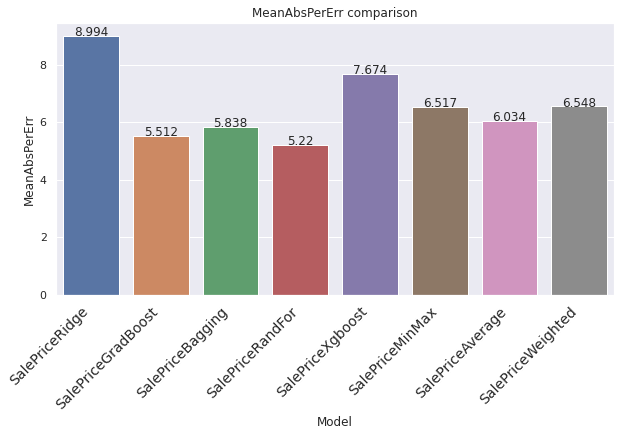

In [66]:
# Camparing MeanAbsPerErr five best models and three created hibrid models models by bar graph
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center') 
if __name__ == '__main__':

  x=accuracy_df_t['Model']
  y=accuracy_df_t['MeanAbsPerErr'].round(3)
  plt.figure(figsize=(10,5))
  plt.title('MeanAbsPerErr comparison')
  ax = sns.barplot(x, y)
  addlabels(x, y)
  ax.set_xticklabels(labels = accuracy_df_t['Model'], rotation=45, horizontalalignment='right',size=14)

  plt.show()

### Comparison of Actual and predicted prices by scatter plots


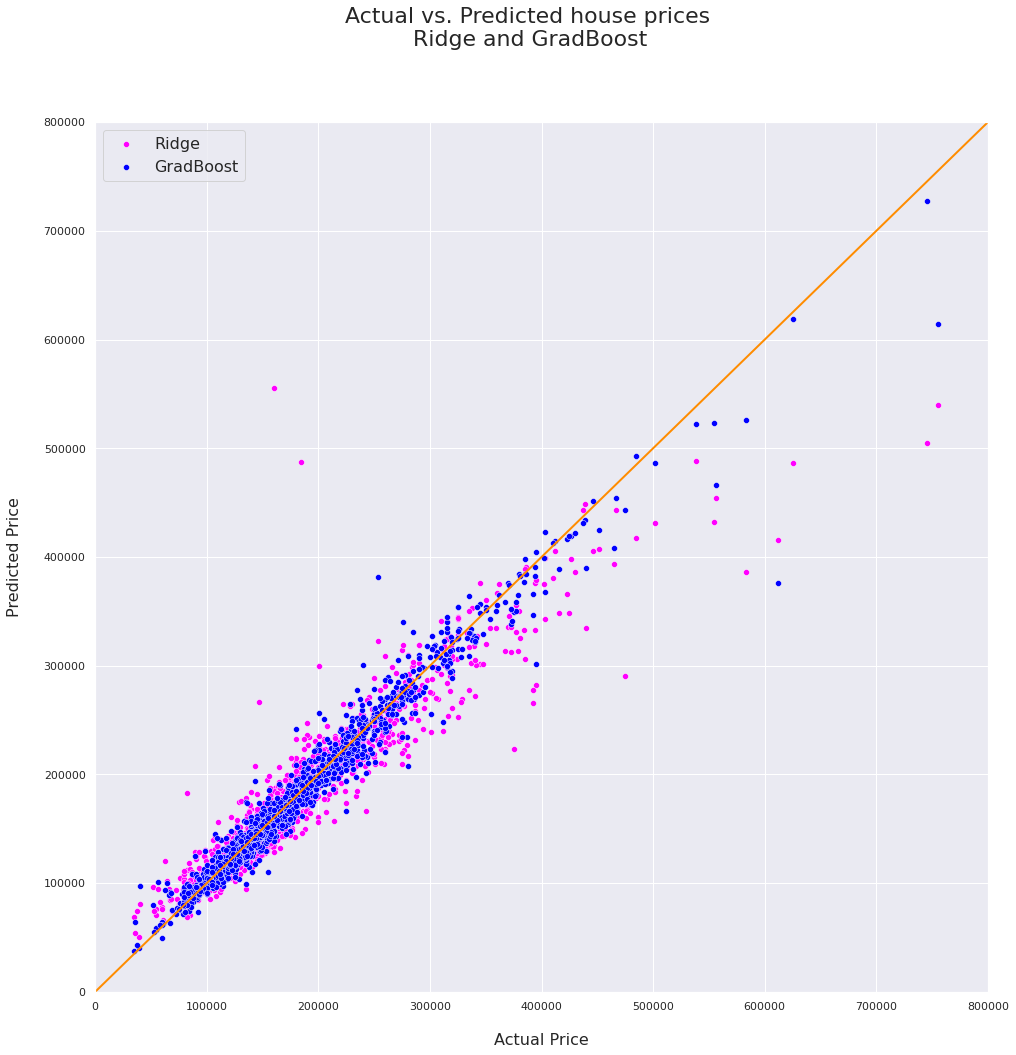

In [67]:
#Scatter plot of actual price and bredicted price by Ridge and GradBoost

import matplotlib.pyplot as plt

x=df_salesprices_with_predictions['ActSalePrice']
y1=df_salesprices_with_predictions['SalePriceRidge']
y2=df_salesprices_with_predictions['SalePriceGradBoost']

plt.figure(figsize=(16,16))
sns.scatterplot(x,y1, color='magenta',label='Ridge')
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)

sns.scatterplot(x,y2, color='blue',label='GradBoost')
plt.ylabel("Predicted Price\n", fontsize=16)
plt.suptitle("Actual vs. Predicted house prices\n Ridge and GradBoost",fontsize=22)
plt.legend(fontsize=16)
plt.show()

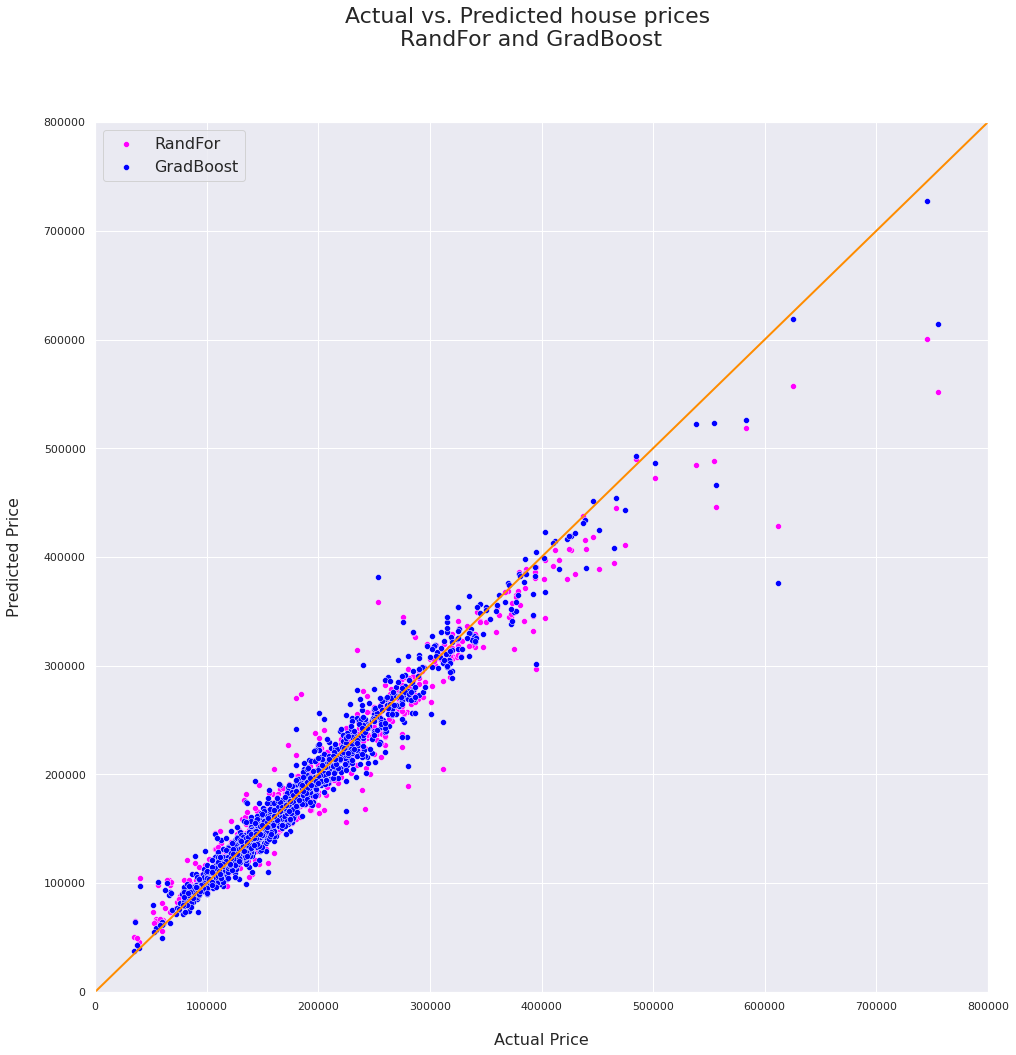

In [68]:
#Scatter plot of actual price and bredicted price by RandFor and GradBoost

import matplotlib.pyplot as plt

x=df_salesprices_with_predictions['ActSalePrice']
y1=df_salesprices_with_predictions['SalePriceRandFor']
y2=df_salesprices_with_predictions['SalePriceGradBoost']

plt.figure(figsize=(16,16))
sns.scatterplot(x,y1, color='magenta',label='RandFor')
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)

sns.scatterplot(x,y2, color='blue',label='GradBoost')
plt.ylabel("Predicted Price\n", fontsize=16)
plt.suptitle("Actual vs. Predicted house prices\n RandFor and GradBoost",fontsize=22)
plt.legend(fontsize=16)
plt.show()

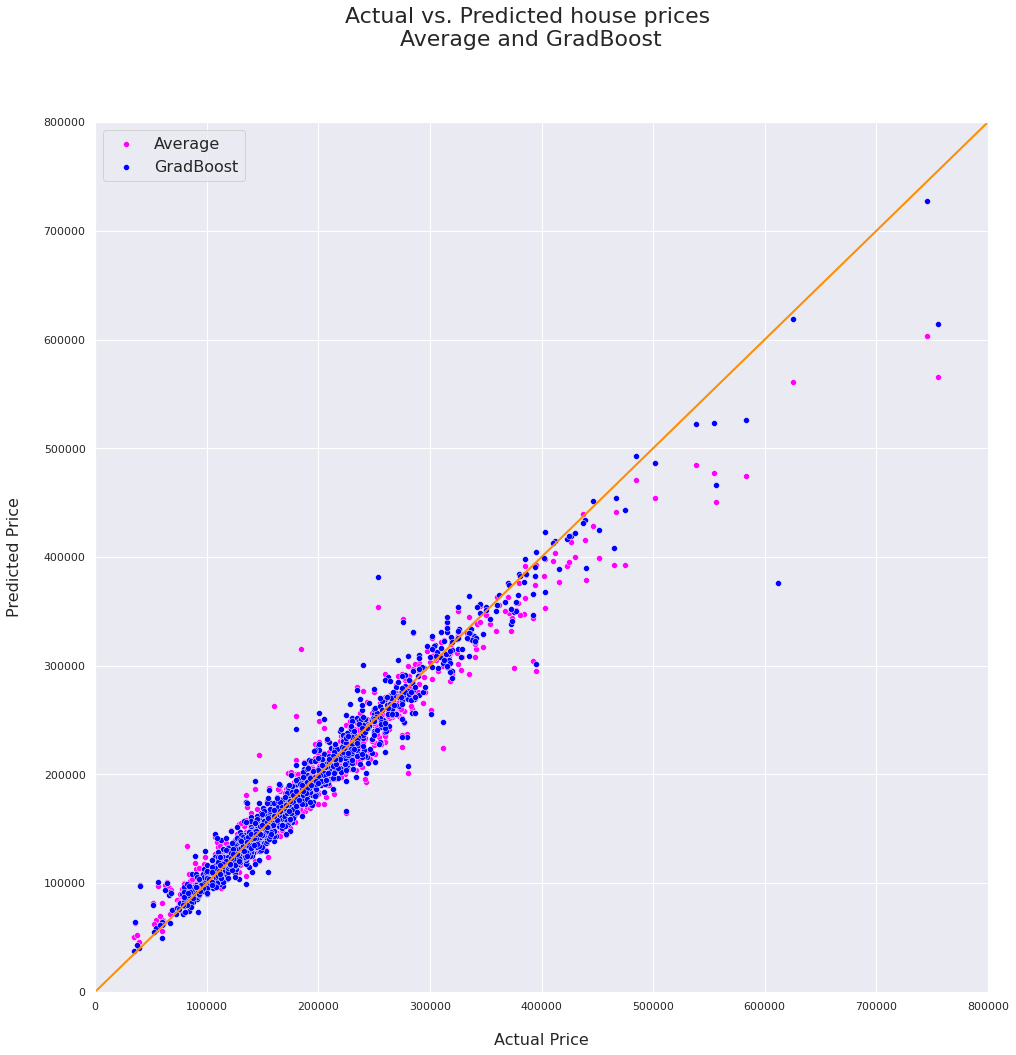

In [69]:
#Scatter plot of actual price and bredicted price by Average and GradBoost

import matplotlib.pyplot as plt

x=df_salesprices_with_predictions['ActSalePrice']
y1=df_salesprices_with_predictions['SalePriceAverage']
y2=df_salesprices_with_predictions['SalePriceGradBoost']

plt.figure(figsize=(16,16))
sns.scatterplot(x,y1, color='magenta',label='Average')
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)

sns.scatterplot(x,y2, color='blue',label='GradBoost')
plt.ylabel("Predicted Price\n", fontsize=16)
plt.suptitle("Actual vs. Predicted house prices\n Average and GradBoost",fontsize=22)
plt.legend(fontsize=16)
plt.show()

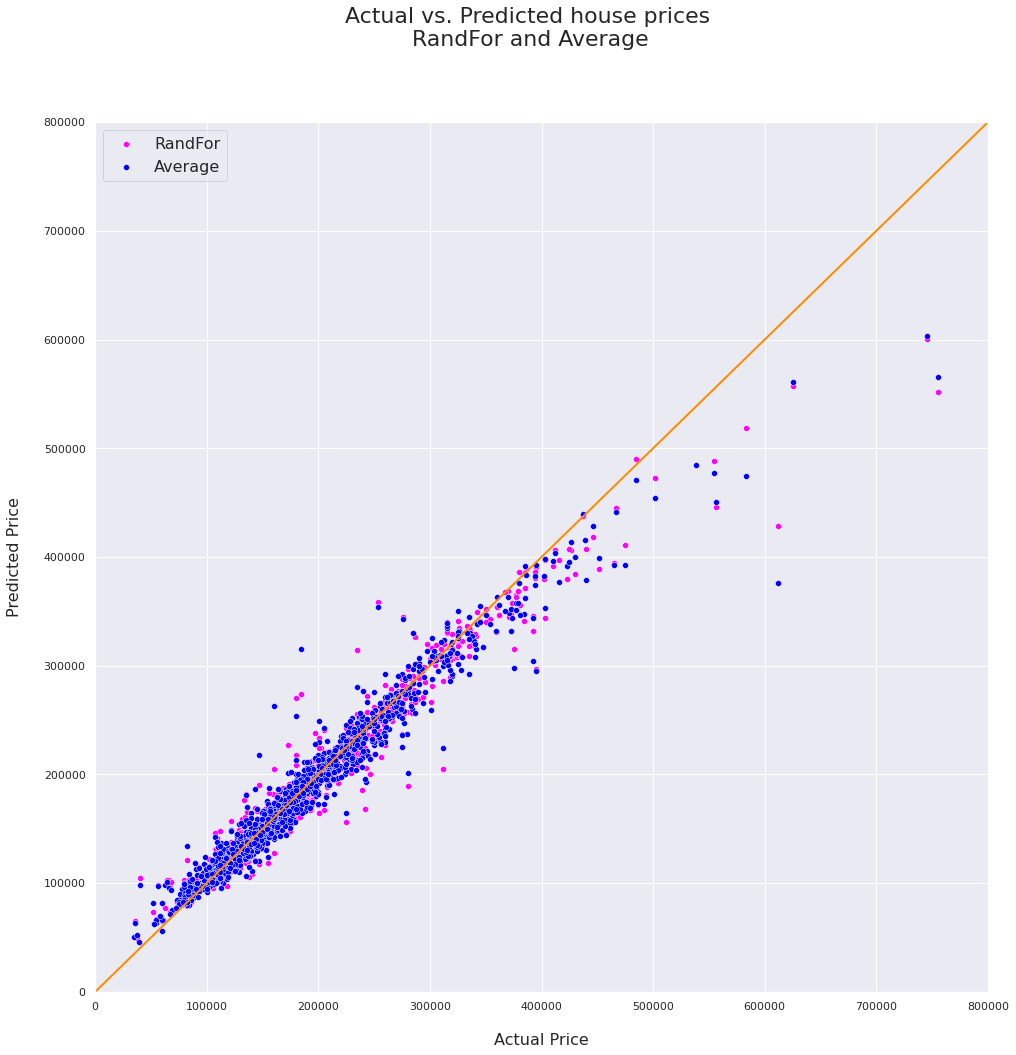

In [70]:
#Scatter plot of actual price and bredicted price by RandFor and Average

import matplotlib.pyplot as plt

x=df_salesprices_with_predictions['ActSalePrice']
y1=df_salesprices_with_predictions['SalePriceRandFor']
y2=df_salesprices_with_predictions['SalePriceAverage']

plt.figure(figsize=(16,16))
sns.scatterplot(x,y1, color='magenta',label='RandFor')
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)

sns.scatterplot(x,y2, color='blue',label='Average')
plt.ylabel("Predicted Price\n", fontsize=16)
plt.suptitle("Actual vs. Predicted house prices\n RandFor and Average",fontsize=22)
plt.legend(fontsize=16)
plt.show()

The comparisons by bar graphs and scatter plots above show that the best method is
   
### GradientBoostingRegressor

Now let's draw residual plot of the best model and find out the most important five features of the model.

In [71]:
best_model=GradientBoostingRegressor(n_estimators=500,max_leaf_nodes=5)
best_model.fit(X_train,y_train)

GradientBoostingRegressor(max_leaf_nodes=5, n_estimators=500)

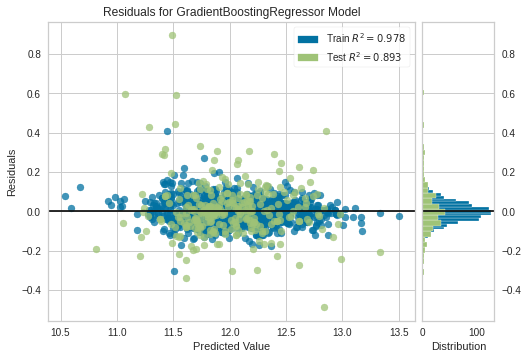

In [72]:
# Residual Plots of results drawn by Best Method
from yellowbrick.regressor import PredictionError, ResidualsPlot
visualizer = ResidualsPlot(best_model)
visualizer.fit(np.array(X_train), np.array(y_train).reshape(1168,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(292,))
visualizer.show();

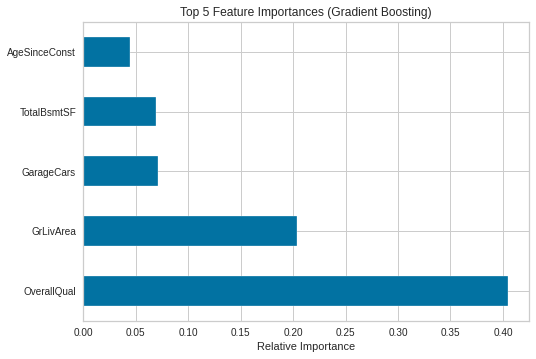

In [73]:
# Five the most important features according to best model
feature_importance = best_model.feature_importances_
features_importances = pd.Series(feature_importance,index=X.columns)
features_importances.nlargest(5).plot(kind='barh', color='b')
plt.title('Top 5 Feature Importances (Gradient Boosting)')
plt.xlabel('Relative Importance')
plt.show()

In [74]:
# Create the dataa Frame which contains the actual prices, 
#the best pridicted prices and absolute percentage error of each record.
absolute_percentage_error=100*np.abs(df_salesprices_with_predictions['ActSalePrice']-df_salesprices_with_predictions['SalePriceGradBoost'])/df_salesprices_with_predictions['ActSalePrice']
best_predicted_prices=pd.DataFrame({"ActualSalePrice": df_salesprices_with_predictions['ActSalePrice'],"BestPredictedSalePrice": df_salesprices_with_predictions['SalePriceGradBoost'],"AbsolutePercentageError(%)":absolute_percentage_error})
best_predicted_prices.head(20)

,ActualSalePrice,BestPredictedSalePrice,AbsolutePercentageError(%)
0,208500,"204,628.33",1.86
1,181500,"176,425.86",2.80
2,223500,"206,374.14",7.66
3,140000,"154,088.65",10.06
4,250000,"278,603.23",11.44
5,143000,"144,149.28",0.80
6,307000,"297,755.42",3.01
7,200000,"214,843.59",7.42
8,129900,"136,872.85",5.37
9,118000,"122,408.43",3.74


### Loading the results in a aws database 

In [76]:
import os
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Ge

In [77]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-07-28 04:42:39--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  5.69MB/s    in 0.2s    

2022-07-28 04:42:40 (5.69 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [78]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [79]:
from pyspark import SparkFiles

# Store environmental variable
from getpass import getpass
password = getpass('********')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://houseprices11.cbchqixwjhxz.us-east-2.rds.amazonaws.com:5432/houseprices"
config = {"user":"postgres",
          "password": password,
          "driver":"org.postgresql.Driver"}

finaldal··········


In [80]:
predictions_df=spark.createDataFrame(df_salesprices_with_predictions)
accuracy=spark.createDataFrame(accuracy_df)
accuracy.show()

+--------------+------------------+----------------+----------------+----------------+---------------+----------------+-----------------+
|SalePriceRidge|SalePriceGradBoost|SalePriceBagging|SalePriceRandFor|SalePriceXgboost|SalePriceMinMax|SalePriceAverage|SalePriceWeighted|
+--------------+------------------+----------------+----------------+----------------+---------------+----------------+-----------------+
|         8.994|             5.512|           5.838|            5.22|           7.674|          6.517|           6.034|            6.548|
|         0.938|             0.981|           0.971|            0.98|           0.962|          0.971|           0.976|            0.971|
+--------------+------------------+----------------+----------------+----------------+---------------+----------------+-----------------+



In [81]:
# Write accuracy DataFrame to accuracy table in RDS
accuracy.write.jdbc(url=jdbc_url, table='accuracy', mode=mode, properties=config)

In [82]:
# Write predictions_df DataFrame to predictions table in RDS
predictions_df.write.jdbc(url=jdbc_url, table='predictions', mode=mode, properties=config)